In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
import tkinter.filedialog as tkf
import hyperspy.api as hys
from scipy import optimize
from ipywidgets import interact
import ipywidgets as widgets
import time

In [ ]:
hys.preferences.gui()

In [2]:
# refer to https://scipy-cookbook.readthedocs.io/items/FittingData.html

def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape) # row, col
    x = (X*data).sum()/total # row
    y = (Y*data).sum()/total # col
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum()) # row
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum()) # col
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

In [3]:
# refer to "github.com/mkolopanis/python/blob/master/radialProfile.py"

def radial_average_with_center(image, profile_resolution=1.0, center=None):
   
    y, x = np.indices(image.shape) * profile_resolution
    if not center:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
        
    r = np.hypot(y - center[0]*profile_resolution, x - center[1]*profile_resolution)
    #plt.imshow(r, cmap="Accent")
    #plt.show()

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = np.around(r_sorted)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    #print(nr)
    
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

In [4]:
def gaussian_center(image, cbox_edge=0):
    y, x = np.indices(image.shape)
    if not cbox_edge:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
        
    else:
        cbox_outy = int(image.shape[0]/2 - cbox_edge/2)
        cbox_outx = int(image.shape[1]/2 - cbox_edge/2)
        center_box = image[cbox_outy:-cbox_outy, cbox_outx:-cbox_outx]
        fit_params = fitgaussian(center_box)
        (_, center_y, center_x, _, _) = fit_params
        center = [center_y+cbox_outy, center_x+cbox_outx]
        
    return center

In [5]:
def remove_center_beam(image, center=None, cb_rad=0):
    y, x = np.indices(image.shape)
    if not center:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
        
    r = np.hypot(y - center[0], x - center[1])
    r = np.around(r)
    ri = np.where(r<=cb_rad)
    #print(ri[0].shape)
    
    image[ri] = 0
    
    return image

In [6]:
def remove_center_beam_outer(image, center=None, cb_rad=0):
    y, x = np.indices(image.shape)
    if not center:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
        
    r = np.hypot(y - center[0], x - center[1])
    r = np.around(r)
    ri = np.where(r>cb_rad)
    #print(ri[0].shape)
    
    image[ri] = 0
    
    return image

In [7]:
# refer to github.com/mkolopanis/python/blob/master/radialProfile.py

def radial_variance_norm(image, profile_resolution=1.0, center=None):
   
    y, x = np.indices(image.shape) * profile_resolution
    if not center:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
        
    r = np.hypot(y - center[0]*profile_resolution, x - center[1]*profile_resolution)
    #plt.imshow(r, cmap="Accent")
    #plt.show()

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = np.around(r_sorted)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    csim = np.cumsum(i_sorted, dtype=float)
    sq_csim = np.cumsum(np.square(i_sorted), dtype=float)
    
    #plt.plot(np.square(csim), c="red")
    #plt.plot(sq_csim, c="blue")
    
    avg_square = np.square((csim[rind[1:]] - csim[rind[:-1]]) / nr)
    square_avg = (sq_csim[rind[1:]] - sq_csim[rind[:-1]]) / nr
    
    #plt.plot(avg_square[20:], c="red")
    #plt.plot(square_avg[20:], c="blue")
    
    mask = avg_square.copy()
    mask[np.where(avg_square==0)] = 1.0
    radial_var = (square_avg - avg_square) / mask
    
    return radial_var    

In [8]:
# refer to github.com/mkolopanis/python/blob/master/radialProfile.py

def radial_variance(image, profile_resolution=1.0, center=None):
   
    y, x = np.indices(image.shape) * profile_resolution
    if not center:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
        
    r = np.hypot(y - center[0]*profile_resolution, x - center[1]*profile_resolution)
    #plt.imshow(r, cmap="Accent")
    #plt.show()

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = np.around(r_sorted)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    csim = np.cumsum(i_sorted, dtype=float)
    sq_csim = np.cumsum(np.square(i_sorted), dtype=float)
    
    #plt.plot(np.square(csim), c="red")
    #plt.plot(sq_csim, c="blue")
    
    avg_square = np.square((csim[rind[1:]] - csim[rind[:-1]]) / nr)
    square_avg = (sq_csim[rind[1:]] - sq_csim[rind[:-1]]) / nr
    
    #plt.plot(avg_square[20:], c="red")
    #plt.plot(square_avg[20:], c="blue")
    
    radial_var = square_avg - avg_square
    
    return radial_var    

In [9]:
def radial_variance_with_angle(image, angle_range=None, center=None):
    
    y, x = np.indices(image.shape)
    
    if not center:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
    
    angle_arr = np.zeros(image.shape)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            angle_arr[i, j] = np.angle(complex(x[i, j]-center[1], y[i, j]-center[0]), deg=True)
            
    angle_arr = angle_arr + 180
    angle_arr = np.around(angle_arr)

    r = np.hypot(y - center[0], x - center[1])
    
    r_int_map = np.around(r)
    
    if angle_range[0] < angle_range[1]:
        sel_img = image.copy()
        sel_img[np.where(angle_arr < angle_range[0])] = 0
        sel_img[np.where(angle_arr > angle_range[1])] = 0
        
    elif angle_range[0] > angle_range[1]:
        temp_i = image.copy()
        temp_f = image.copy()
        temp_i[np.where(angle_arr < angle_range[0])] = 0
        temp_f[np.where(angle_arr > angle_range[1])] = 0
        sel_img = temp_i + temp_f
        
    else:
        print("wrong angle range")
        exit(1)
    
    sel_ind = np.nonzero(sel_img)
    r_sel_flat = r_int_map[sel_ind]
    i_sel_flat = sel_img[sel_ind]
    r_unique = np.unique(r_sel_flat)[1:-1]
    
    avg_square = np.zeros(r_unique.shape)
    square_avg = np.zeros(r_unique.shape)
    num_rad = np.zeros(r_unique.shape)

    for i in range(len(r_unique)):
        temp_ind = np.where(r_sel_flat==r_unique[i])
        avg_square[i] = np.sum(i_sel_flat[temp_ind])
        square_avg[i] = np.sum(np.square(i_sel_flat[temp_ind]))
        num_rad[i] = len(temp_ind[0])
        
    num_rad[np.where(num_rad == 0)] = 1.0
    avg_square = np.square(avg_square / num_rad)
    square_avg = square_avg / num_rad
    
    #plt.plot(avg_square[20:], c="red")
    #plt.plot(square_avg[20:], c="blue")
    
    radial_var = (square_avg - avg_square) / avg_square    
    #print(radial_var.shape)
       
    return radial_var

In [10]:
def load_binary_4D_stack(img_adr, datatype, original_shape, final_shape, log_scale=False):
    raw_stack = np.fromfile(img_adr, dtype=datatype)
    stack = raw_stack.reshape(original_shape)
    print(stack.shape)
    if log_scale:
        stack = np.log(stack[:final_shape[0], :final_shape[1], :final_shape[2], :final_shape[3]])
    else:
        stack = stack[:final_shape[0], :final_shape[1], :final_shape[2], :final_shape[3]]
    
    print(stack.shape) 
    return stack

In [24]:
raw_adr = tkf.askopenfilename()
print(raw_adr)

E:/data_temporary/20190925_DGIST/raw_data/G4_4_4/scan_x256_y256.raw


In [12]:
#vacuum_cb_intensity = 2087295.0
vacuum_cb_intensity = 2134895.0
datatype = "float32"
o_shape = (256, 256, 130, 128)
f_shape = (256, 256, 128, 128)

In [25]:
# load a data
stack_4d = load_binary_4D_stack(raw_adr, datatype, o_shape, f_shape, log_scale=False)
#stack_4d = stack_4d - np.min(stack_4d)
#stack_4d = stack_4d / np.max(stack_4d) # normalize absolutely
#stack_4d = stack_4d * 1E3
print(np.max(stack_4d))
print(np.min(stack_4d))
print(np.mean(stack_4d))
#print(np.median(stack_4d))

(256, 256, 130, 128)
(256, 256, 128, 128)
1418095.0
1142.0
6018.6206


In [28]:
# select an interesting area
%matplotlib qt
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(np.sum(stack_4d, axis=(2, 3)), cmap="gray")

def onselect(eclick, erelease):
    print('startposition: (%f, %f)' % (eclick.xdata, eclick.ydata))
    print('endposition  : (%f, %f)' % (erelease.xdata, erelease.ydata))

box = RectangleSelector(ax, onselect)
plt.show()

startposition: (98.712771, 2.867939)
endposition  : (161.944834, 250.138587)
startposition: (101.375174, 3.533540)
endposition  : (174.591247, 250.471387)


after cropping...
(247, 73, 128, 128)
1056895.0
1150.0
5677.9644
2142.0
maximum intensities...
(247, 73)
1056895.0
871808.0
952624.56
953238.0


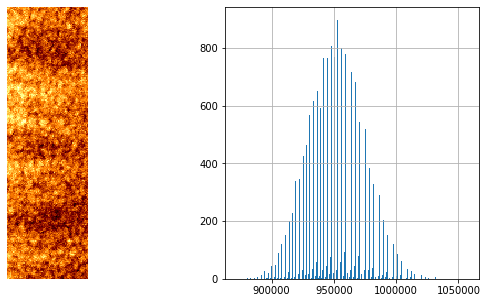

total intensity
(247, 73)
94815060.0
91478670.0
93028020.0
93007150.0


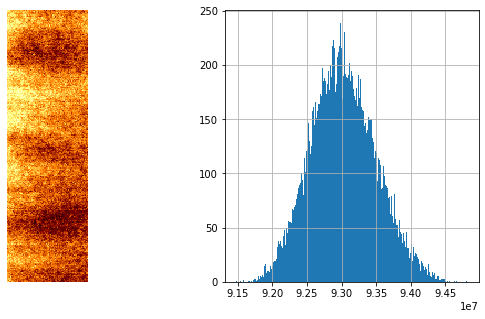

find the position of the center beam...
(247, 73, 2)
[64.53123467 65.84440062]


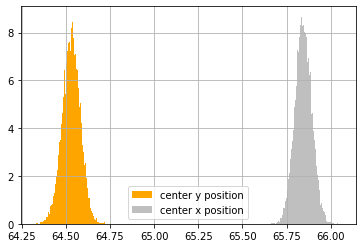

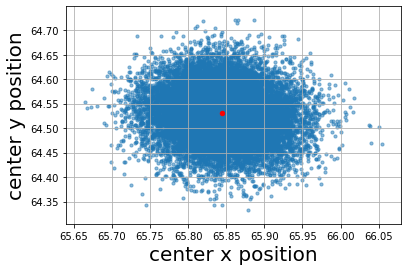

---------------------------------------------------------------
remove center beams...
25303.0
0.0
2151.6814
2023.0
25303.0
0.0
2139.5132
2021.0
background signal mean normlization
2344.4211893677316
2.4219174
10.792856
0.0
0.9177873
0.86289954
obtain k-point variance map...
0.5990987
0.0
0.05502343


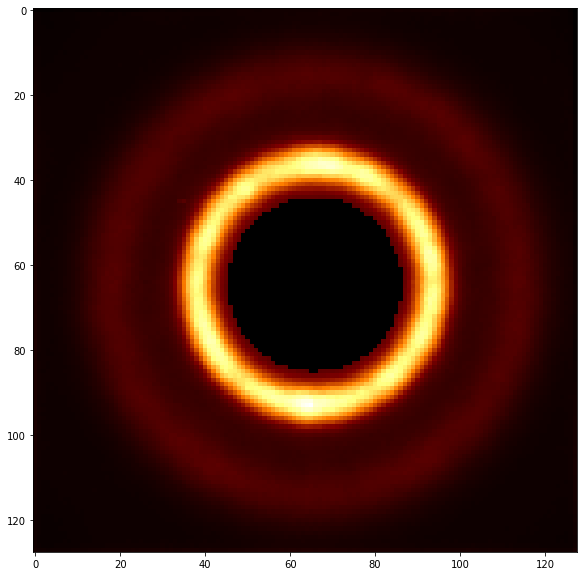

(91,)


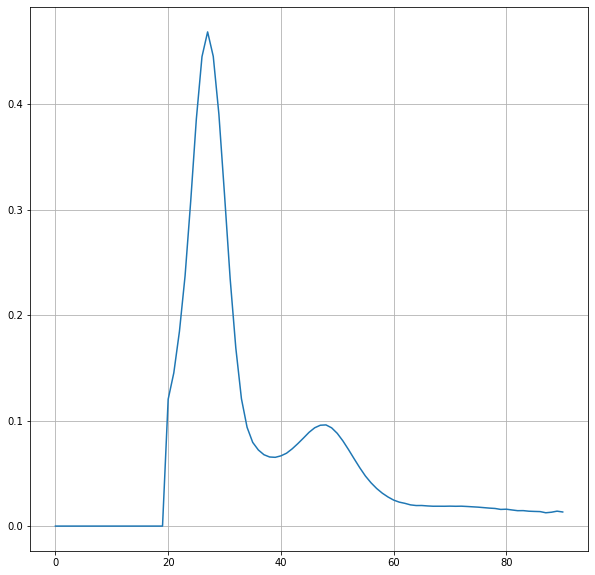

calculate radial variance and save... (the same mean)
(247, 73, 91)
(91,)


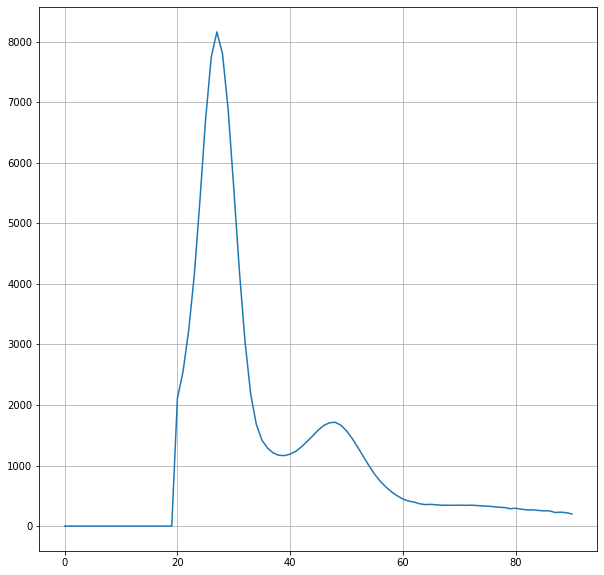

---------------------------------------------------------------
remove center beams...
6663.0
0.0
344.4711
0.0
6663.0
0.0
297.33765
0.0
background signal mean normlization
1836.9456658061576
3.0909948
13.774495
0.0
1.1713313
1.1012846
obtain k-point variance map...
0.9758606
0.0
0.089628935


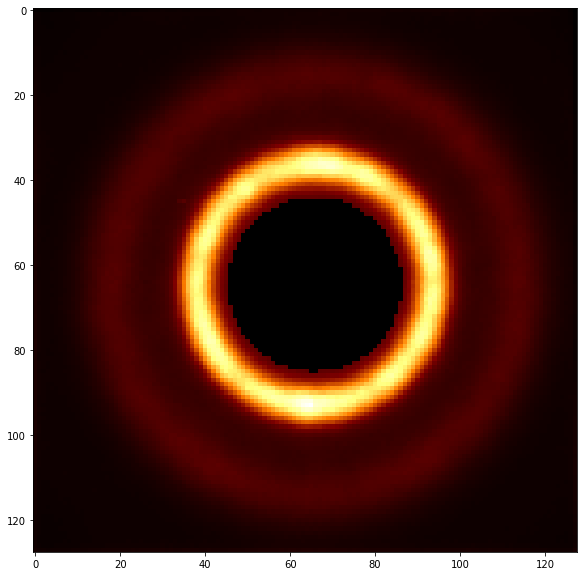

(91,)


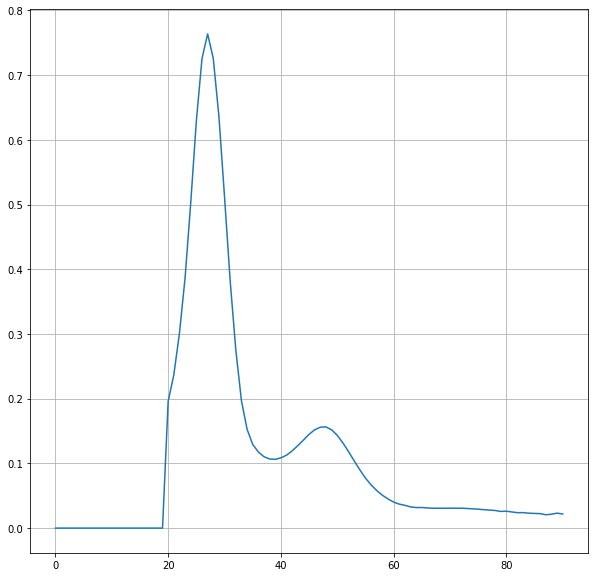

calculate radial variance and save... (background signal mean normalization)
(247, 73, 91)
(91,)


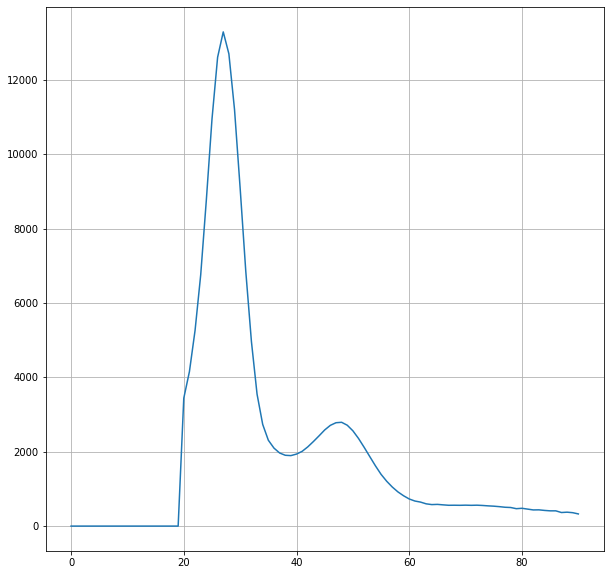

---------------------------------------------------------------
remove center beams...
25303.0
0.0
2151.6814
2023.0
25303.0
0.0
2139.5132
2021.0
radial variance + mean normalization + background signal mean normlization
2344.4211893677316
25303.0
0.0
2151.6814
2023.0
obtain k-point variance map...
3292966.0
0.0
302457.25


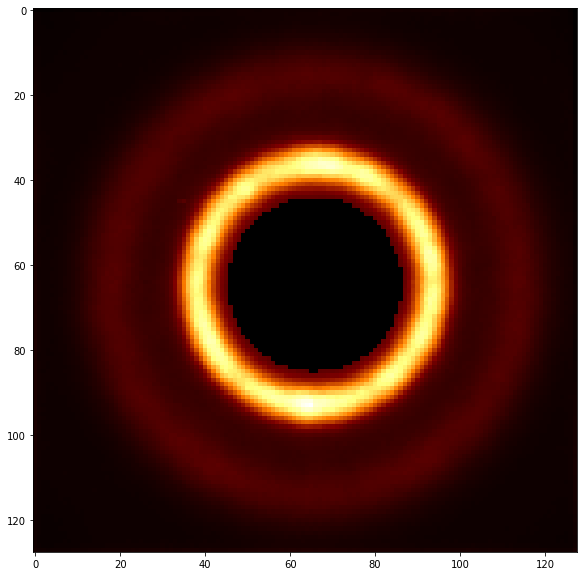

(91,)


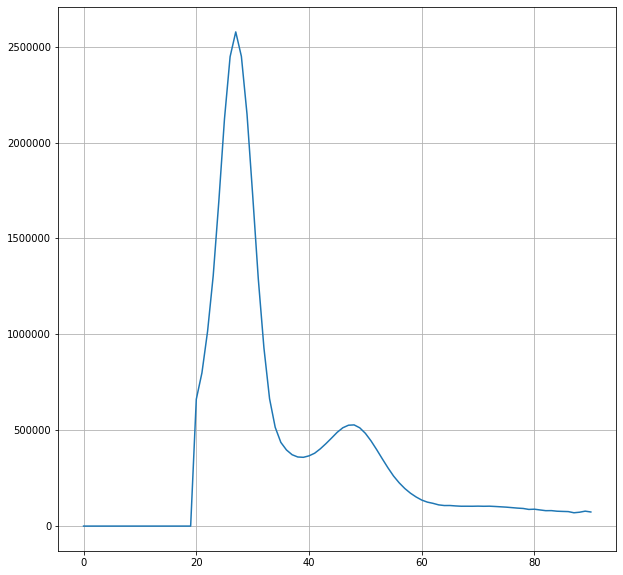

calculate radial variance and save... (background signal mean normalization)
(247, 73, 91)
(91,)


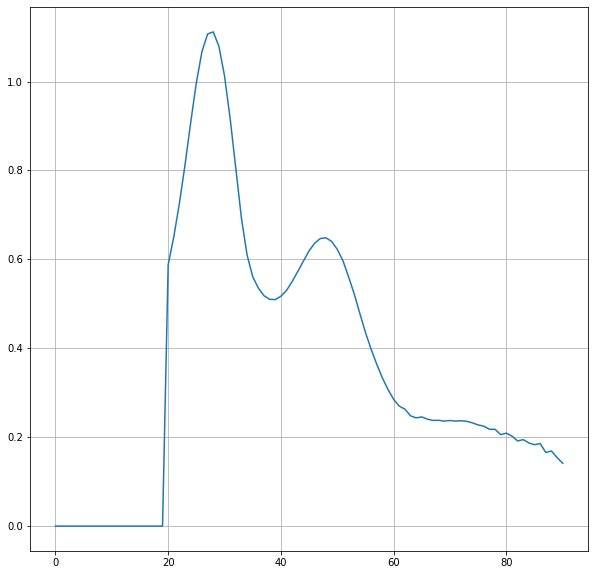

---------------------------------------------------------------
remove center beams...
6663.0
0.0
344.4711
0.0
6663.0
0.0
297.33765
0.0
radial variance + mean normalization + background signal mean normlization
1836.9456658061576
25303.0
0.0
2151.6814
2023.0
obtain k-point variance map...
3292966.0
0.0
302457.25


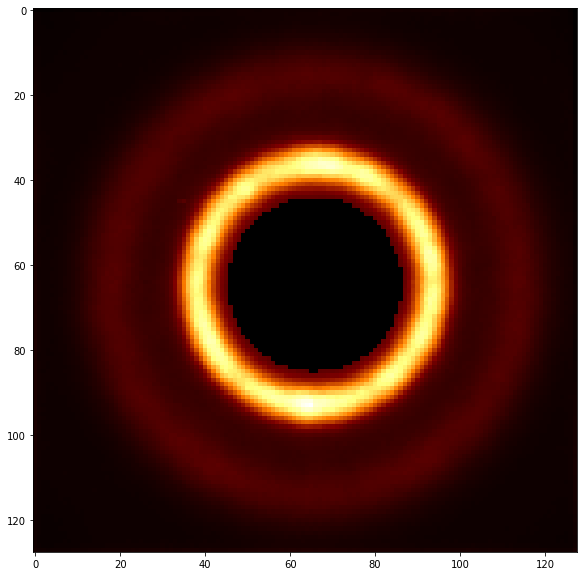

(91,)


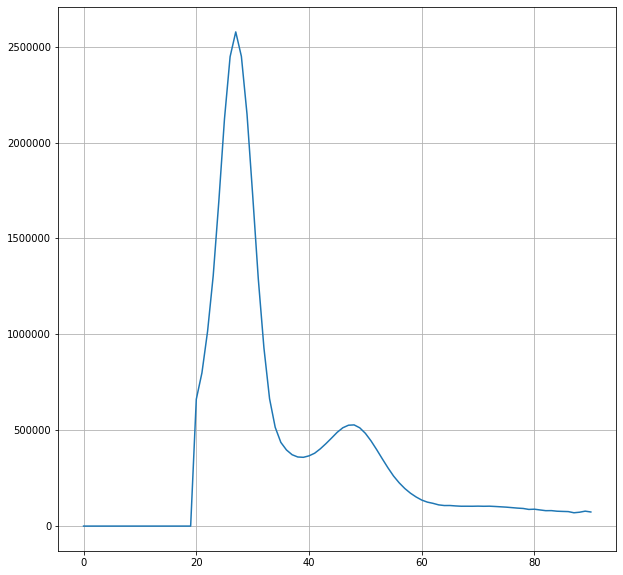

calculate radial variance and save... (background signal mean normalization)
(247, 73, 91)
(91,)


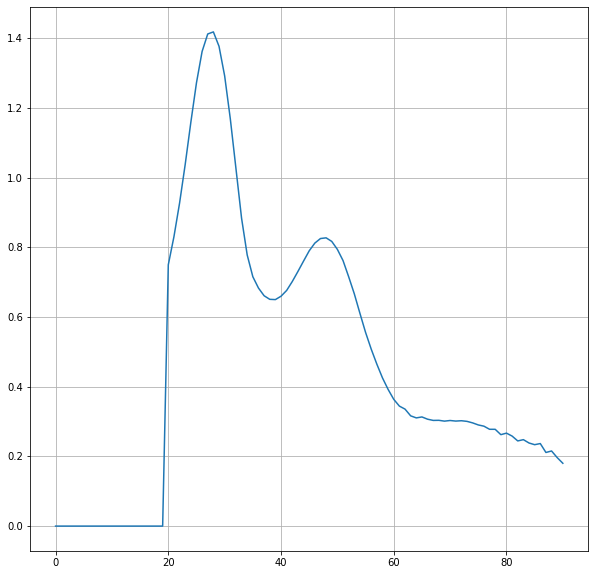

In [29]:
%matplotlib inline

# crop the data
stack_4d_cropped = stack_4d[int(box.corners[1][0]):int(box.corners[1][2]), 
                                           int(box.corners[0][0]):int(box.corners[0][1])].copy()
print("after cropping...")
print(stack_4d_cropped.shape)
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
print(np.median(stack_4d_cropped))


# maximum intensity distribution
print("maximum intensities...")
max_int = np.max(stack_4d_cropped, axis=(2, 3))
print(max_int.shape)
print(np.max(max_int))
print(np.min(max_int))
print(np.mean(max_int))
print(np.median(max_int))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(max_int, cmap="afmhot")
ax[0].axis("off")
ax[1].hist(max_int.flatten(), bins=len(max_int))
ax[1].grid()
plt.show()

# total intensity distribution
print("total intensity")
tot_int = np.sum(stack_4d_cropped, axis=(2, 3))
print(tot_int.shape)
print(np.max(tot_int))
print(np.min(tot_int))
print(np.mean(tot_int))
print(np.median(tot_int))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(tot_int, cmap="afmhot")
ax[0].axis("off")
ax[1].hist(tot_int.flatten(), bins=len(tot_int))
ax[1].grid()
plt.show()


# find center position
print("find the position of the center beam...")
center_pos = []
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        center_pos.append(gaussian_center(stack_4d_cropped[i, j], cbox_edge=30))
        
center_pos = np.asarray(center_pos)
center_pos = np.reshape(center_pos, (stack_4d_cropped.shape[0], stack_4d_cropped.shape[1], -1))
print(center_pos.shape)
center_mean = np.mean(center_pos, axis=(0, 1))
print(center_mean)

# center distibution
plt.figure()
plt.hist(center_pos[:, :, 0].flatten(), bins=100, density=True, color="orange", label="center y position")
plt.hist(center_pos[:, :, 1].flatten(), bins=100, density=True, color="gray", alpha=0.5, label="center x position")
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.scatter(center_pos[:, :, 1], center_pos[:, :, 0], s=10.0, alpha=0.5)
plt.grid()
plt.scatter(center_mean[1], center_mean[0], s=20, c="red")
plt.xlabel("center x position", fontsize=20)
plt.ylabel("center y position", fontsize=20)
plt.show()


print("---------------------------------------------------------------")

stack_4d_cropped = stack_4d[int(box.corners[1][0]):int(box.corners[1][2]), 
                                           int(box.corners[0][0]):int(box.corners[0][1])].copy()

# remove center beam
print("remove center beams...")
center_radius = 20
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        stack_4d_cropped[i, j] = remove_center_beam(stack_4d_cropped[i, j], 
                                                    center=center_mean.tolist(), cb_rad=center_radius)
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
print(np.median(stack_4d_cropped))

center_radius = 85
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        stack_4d_cropped[i, j] = remove_center_beam_outer(stack_4d_cropped[i, j], 
                                                    center=center_mean.tolist(), cb_rad=center_radius)
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
print(np.median(stack_4d_cropped))


# make the mean value a certain value for all the data
print("background signal mean normlization")
stack_4d_flat = stack_4d_cropped.flatten()
back_mean = np.sum(stack_4d_flat) / len(np.nonzero(stack_4d_flat)[0])
print(back_mean)
cor_term = 1.0 / back_mean

stack_4d_cropped = stack_4d[int(box.corners[1][0]):int(box.corners[1][2]), 
                                           int(box.corners[0][0]):int(box.corners[0][1])].copy()
stack_4d_cropped *= cor_term
print(np.mean(stack_4d_cropped))

center_radius = 20
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        stack_4d_cropped[i, j] = remove_center_beam(stack_4d_cropped[i, j], 
                                                    center=center_mean.tolist(), cb_rad=center_radius)
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
print(np.median(stack_4d_cropped))

# obtain variance map dpending on k-vector
print("obtain k-point variance map...")
square_avg = np.mean(np.square(stack_4d_cropped), axis=(0,1))
avg_square = np.square(np.mean(stack_4d_cropped, axis=(0,1)))
var_map = (square_avg - avg_square)
print(np.max(var_map))
print(np.min(var_map))
print(np.median(var_map))
plt.figure(figsize=(10,10))
plt.imshow(var_map, cmap="afmhot")
plt.show()

# obtain radial average prifile for variance map above
kp_var = radial_average_with_center(var_map, center=center_mean.tolist())
print(kp_var.shape)

plt.figure(figsize=(10,10))
plt.plot(kp_var)
plt.grid()
plt.show()

# calculate variance with all angles at a certain k
print("calculate radial variance and save... (the same mean)")
radial_var_stack = []
len_profile = []
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        radial_temp = radial_variance(stack_4d_cropped[i, j], center=center_mean.tolist())
        len_profile.append(len(radial_temp))
        radial_var_stack.append(radial_temp)

if len(np.unique(len_profile)) > 1:
    print(np.unique(len_profile))
    shortest = np.min(len_profile)
    for i in range(len(len_profile)):
        radial_var_stack[i] = radial_var_stack[i][:shortest]

radial_var_stack = np.asarray(radial_var_stack).reshape(stack_4d_cropped.shape[0], stack_4d_cropped.shape[1], -1)
print(radial_var_stack.shape)

radial_var_sum = np.sum(radial_var_stack, axis=(0, 1))
print(radial_var_sum.shape)

plt.figure(figsize=(10,10))
plt.plot(radial_var_sum)
plt.grid()
plt.show()

# save (radial variance, 3D)
radial_var_stack = hys.signals.Signal1D(radial_var_stack)
radial_var_stack.metadata.General.set_item("notes", center_mean.tolist())
radial_var_stack.save(raw_adr[:-4]+"_radial_var_radial_background_signal_norm_20_85.hdf5")


print("---------------------------------------------------------------")

stack_4d_cropped = stack_4d[int(box.corners[1][0]):int(box.corners[1][2]), 
                                           int(box.corners[0][0]):int(box.corners[0][1])].copy()

# remove center beam
print("remove center beams...")
center_radius = 65
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        stack_4d_cropped[i, j] = remove_center_beam(stack_4d_cropped[i, j], 
                                                    center=center_mean.tolist(), cb_rad=center_radius)
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
print(np.median(stack_4d_cropped))

center_radius = 80
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        stack_4d_cropped[i, j] = remove_center_beam_outer(stack_4d_cropped[i, j], 
                                                    center=center_mean.tolist(), cb_rad=center_radius)
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
print(np.median(stack_4d_cropped))


# make the mean value a certain value for all the data
print("background signal mean normlization")
stack_4d_flat = stack_4d_cropped.flatten()
back_mean = np.sum(stack_4d_flat) / len(np.nonzero(stack_4d_flat)[0])
print(back_mean)
cor_term = 1.0 / back_mean

stack_4d_cropped = stack_4d[int(box.corners[1][0]):int(box.corners[1][2]), 
                                           int(box.corners[0][0]):int(box.corners[0][1])].copy()
stack_4d_cropped *= cor_term
print(np.mean(stack_4d_cropped))

center_radius = 20
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        stack_4d_cropped[i, j] = remove_center_beam(stack_4d_cropped[i, j], 
                                                    center=center_mean.tolist(), cb_rad=center_radius)
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
print(np.median(stack_4d_cropped))

# obtain variance map dpending on k-vector
print("obtain k-point variance map...")
square_avg = np.mean(np.square(stack_4d_cropped), axis=(0,1))
avg_square = np.square(np.mean(stack_4d_cropped, axis=(0,1)))
var_map = (square_avg - avg_square)
print(np.max(var_map))
print(np.min(var_map))
print(np.median(var_map))
plt.figure(figsize=(10,10))
plt.imshow(var_map, cmap="afmhot")
plt.show()

# obtain radial average prifile for variance map above
kp_var = radial_average_with_center(var_map, center=center_mean.tolist())
print(kp_var.shape)

plt.figure(figsize=(10,10))
plt.plot(kp_var)
plt.grid()
plt.show()

# calculate variance with all angles at a certain k
print("calculate radial variance and save... (background signal mean normalization)")
radial_var_stack = []
len_profile = []
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        radial_temp = radial_variance(stack_4d_cropped[i, j], center=center_mean.tolist())
        len_profile.append(len(radial_temp))
        radial_var_stack.append(radial_temp)

if len(np.unique(len_profile)) > 1:
    print(np.unique(len_profile))
    shortest = np.min(len_profile)
    for i in range(len(len_profile)):
        radial_var_stack[i] = radial_var_stack[i][:shortest]

radial_var_stack = np.asarray(radial_var_stack).reshape(stack_4d_cropped.shape[0], stack_4d_cropped.shape[1], -1)
print(radial_var_stack.shape)

radial_var_sum = np.sum(radial_var_stack, axis=(0, 1))
print(radial_var_sum.shape)

plt.figure(figsize=(10,10))
plt.plot(radial_var_sum)
plt.grid()
plt.show()

# save (radial variance, 3D)
radial_var_stack = hys.signals.Signal1D(radial_var_stack)
radial_var_stack.metadata.General.set_item("notes", center_mean.tolist())
radial_var_stack.save(raw_adr[:-4]+"_radial_var_radial_background_signal_norm_65_80.hdf5")


print("---------------------------------------------------------------")

stack_4d_cropped = stack_4d[int(box.corners[1][0]):int(box.corners[1][2]), 
                                           int(box.corners[0][0]):int(box.corners[0][1])].copy()

# remove center beam
print("remove center beams...")
center_radius = 20
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        stack_4d_cropped[i, j] = remove_center_beam(stack_4d_cropped[i, j], 
                                                    center=center_mean.tolist(), cb_rad=center_radius)
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
print(np.median(stack_4d_cropped))

center_radius = 85
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        stack_4d_cropped[i, j] = remove_center_beam_outer(stack_4d_cropped[i, j], 
                                                    center=center_mean.tolist(), cb_rad=center_radius)
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
print(np.median(stack_4d_cropped))


# make the mean value a certain value for all the data
print("radial variance + mean normalization + background signal mean normlization")
stack_4d_flat = stack_4d_cropped.flatten()
back_mean = np.sum(stack_4d_flat) / len(np.nonzero(stack_4d_flat)[0])
print(back_mean)
cor_term = 1.0 / back_mean


stack_4d_cropped = stack_4d[int(box.corners[1][0]):int(box.corners[1][2]), 
                                           int(box.corners[0][0]):int(box.corners[0][1])].copy()

center_radius = 20
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        stack_4d_cropped[i, j] = remove_center_beam(stack_4d_cropped[i, j], 
                                                    center=center_mean.tolist(), cb_rad=center_radius)
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
print(np.median(stack_4d_cropped))

# obtain variance map dpending on k-vector
print("obtain k-point variance map...")
square_avg = np.mean(np.square(stack_4d_cropped), axis=(0,1))
avg_square = np.square(np.mean(stack_4d_cropped, axis=(0,1)))
var_map = (square_avg - avg_square)
print(np.max(var_map))
print(np.min(var_map))
print(np.median(var_map))
plt.figure(figsize=(10,10))
plt.imshow(var_map, cmap="afmhot")
plt.show()

# obtain radial average prifile for variance map above
kp_var = radial_average_with_center(var_map, center=center_mean.tolist())
print(kp_var.shape)

plt.figure(figsize=(10,10))
plt.plot(kp_var)
plt.grid()
plt.show()

# calculate variance with all angles at a certain k
print("calculate radial variance and save... (background signal mean normalization)")
radial_var_stack = []
len_profile = []
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        radial_temp = radial_variance_norm(stack_4d_cropped[i, j], center=center_mean.tolist())
        len_profile.append(len(radial_temp))
        radial_var_stack.append(radial_temp)

if len(np.unique(len_profile)) > 1:
    print(np.unique(len_profile))
    shortest = np.min(len_profile)
    for i in range(len(len_profile)):
        radial_var_stack[i] = radial_var_stack[i][:shortest]

radial_var_stack = np.asarray(radial_var_stack).reshape(stack_4d_cropped.shape[0], stack_4d_cropped.shape[1], -1)
print(radial_var_stack.shape)

radial_var_stack *= cor_term

radial_var_sum = np.sum(radial_var_stack, axis=(0, 1))
print(radial_var_sum.shape)

plt.figure(figsize=(10,10))
plt.plot(radial_var_sum)
plt.grid()
plt.show()

# save (radial variance, 3D)
radial_var_stack = hys.signals.Signal1D(radial_var_stack)
radial_var_stack.metadata.General.set_item("notes", center_mean.tolist())
radial_var_stack.save(raw_adr[:-4]+"_radial_var_mean_variance_background_signal_norm_20_85.hdf5")

print("---------------------------------------------------------------")

stack_4d_cropped = stack_4d[int(box.corners[1][0]):int(box.corners[1][2]), 
                                           int(box.corners[0][0]):int(box.corners[0][1])].copy()

# remove center beam
print("remove center beams...")
center_radius = 65
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        stack_4d_cropped[i, j] = remove_center_beam(stack_4d_cropped[i, j], 
                                                    center=center_mean.tolist(), cb_rad=center_radius)
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
print(np.median(stack_4d_cropped))

center_radius = 80
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        stack_4d_cropped[i, j] = remove_center_beam_outer(stack_4d_cropped[i, j], 
                                                    center=center_mean.tolist(), cb_rad=center_radius)
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
print(np.median(stack_4d_cropped))


# make the mean value a certain value for all the data
print("radial variance + mean normalization + background signal mean normlization")
stack_4d_flat = stack_4d_cropped.flatten()
back_mean = np.sum(stack_4d_flat) / len(np.nonzero(stack_4d_flat)[0])
print(back_mean)
cor_term = 1.0 / back_mean


stack_4d_cropped = stack_4d[int(box.corners[1][0]):int(box.corners[1][2]), 
                                           int(box.corners[0][0]):int(box.corners[0][1])].copy()

center_radius = 20
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        stack_4d_cropped[i, j] = remove_center_beam(stack_4d_cropped[i, j], 
                                                    center=center_mean.tolist(), cb_rad=center_radius)
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
print(np.median(stack_4d_cropped))

# obtain variance map dpending on k-vector
print("obtain k-point variance map...")
square_avg = np.mean(np.square(stack_4d_cropped), axis=(0,1))
avg_square = np.square(np.mean(stack_4d_cropped, axis=(0,1)))
var_map = (square_avg - avg_square)
print(np.max(var_map))
print(np.min(var_map))
print(np.median(var_map))
plt.figure(figsize=(10,10))
plt.imshow(var_map, cmap="afmhot")
plt.show()

# obtain radial average prifile for variance map above
kp_var = radial_average_with_center(var_map, center=center_mean.tolist())
print(kp_var.shape)

plt.figure(figsize=(10,10))
plt.plot(kp_var)
plt.grid()
plt.show()

# calculate variance with all angles at a certain k
print("calculate radial variance and save... (background signal mean normalization)")
radial_var_stack = []
len_profile = []
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        radial_temp = radial_variance_norm(stack_4d_cropped[i, j], center=center_mean.tolist())
        len_profile.append(len(radial_temp))
        radial_var_stack.append(radial_temp)

if len(np.unique(len_profile)) > 1:
    print(np.unique(len_profile))
    shortest = np.min(len_profile)
    for i in range(len(len_profile)):
        radial_var_stack[i] = radial_var_stack[i][:shortest]

radial_var_stack = np.asarray(radial_var_stack).reshape(stack_4d_cropped.shape[0], stack_4d_cropped.shape[1], -1)
print(radial_var_stack.shape)

radial_var_stack *= cor_term

radial_var_sum = np.sum(radial_var_stack, axis=(0, 1))
print(radial_var_sum.shape)

plt.figure(figsize=(10,10))
plt.plot(radial_var_sum)
plt.grid()
plt.show()

# save (radial variance, 3D)
radial_var_stack = hys.signals.Signal1D(radial_var_stack)
radial_var_stack.metadata.General.set_item("notes", center_mean.tolist())
radial_var_stack.save(raw_adr[:-4]+"_radial_var_mean_variance_background_signal_norm_65_80.hdf5")